## ANALISIS SENTIMENT KOMENTAR APLIKASI INSTAGRAM DI PLAYSTORE DENGAN MENGGUNAKAN ALGORITMA NAIVE BAYES DAN LOGISTIC REGRESSION

## IMPORT LIBRARY

In [ ]:
!pip install google-play-scraper

In [ ]:
!pip install Sastrawi
!pip install swifter
!pip install wordcloud
!pip install matplotlib
!pip install scikit-learn

In [ ]:
import csv
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google_play_scraper import app
from google_play_scraper import Sort, reviews
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from time import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## SCRAPING

In [ ]:
from google_play_scraper import Sort, reviews

app_id = 'com.instagram.android'

def get_reviews(app_id, lang='id', count=3000, sort=Sort.NEWEST, filter_score_with=None, filter_device_with=None, sleep_milliseconds=0):
    continuation_token = None  # <-- Inisialisasi dulu sebelum dipakai!
    try:
        result, continuation_token = reviews(
            app_id,
            lang=lang,
            count=count,
            sort=sort,
            country='id',
            filter_score_with=filter_score_with,
            filter_device_with=filter_device_with,
            continuation_token=continuation_token
        )
        return result, continuation_token
    except Exception as e:
        print('Error:', e)
        return None, None

# Panggil fungsi
reviews_data, continuation_token = get_reviews(app_id)

# Tampilkan hasil
if reviews_data is not None:
    print("Jumlah ulasan:", len(reviews_data))
    if len(reviews_data) > 0:
        print("Ulasan pertama:")
        print(reviews_data[0])
else:
    print("Tidak ada ulasan ditemukan.")


Jumlah ulasan: 3000
Ulasan pertama:
{'reviewId': '05041449-2cd3-4c74-9d89-4ea2b3bbb16e', 'userName': 'Pengguna Google', 'userImage': 'https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g', 'content': 'lumayan', 'score': 5, 'thumbsUpCount': 0, 'reviewCreatedVersion': '375.0.0.38.66', 'at': datetime.datetime(2025, 4, 26, 15, 29, 29), 'replyContent': None, 'repliedAt': None, 'appVersion': '375.0.0.38.66'}


In [ ]:
def export_to_csv(reviews, filename='hasil_Scraping.csv'):
  if reviews:
    fieldname = ["Reviews ID", "userName", "rating", "Text", "Date"]

    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=fieldname)
      writer.writeheader()

      for review in reviews:

        writer.writerow({
          'Reviews ID': review['reviewId'],
          'userName': review['userName'],
          'rating': review['score'],
          'Text': review['content'],
          'Date': review['at']
        })

    print(f"Data berhasil diekspor ke {filename}")

  else:
    print("Tidak ada data untuk di export.")

reviews_data, _ = get_reviews(app_id)

export_to_csv(reviews_data)

Data berhasil diekspor ke hasil_Scraping.csv


In [ ]:
data = pd.read_csv('hasil_Scraping.csv')
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Reviews ID  3000 non-null   object
 1   userName    3000 non-null   object
 2   rating      3000 non-null   int64 
 3   Text        3000 non-null   object
 4   Date        3000 non-null   object
dtypes: int64(1), object(4)
memory usage: 117.3+ KB


In [ ]:
data.head(10)

Reviews ID         userName  rating  \
0  05041449-2cd3-4c74-9d89-4ea2b3bbb16e  Pengguna Google       5   
1  6caf737a-77ef-4c07-8304-3e5ebc7485b8  Pengguna Google       2   
2  deb4f1c5-5fd1-45b0-bde5-1e309accaa73  Pengguna Google       5   
3  2ad8f062-9095-4915-b59b-1981b9a506f7  Pengguna Google       5   
4  89a46d4e-350b-4748-8fbd-c498d2206b4b  Pengguna Google       3   
5  98050130-1e11-49e2-ae75-f999936d5276  Pengguna Google       5   
6  9b2a1fa5-b32c-4a58-8cc5-50feaa9cb28d  Pengguna Google       5   
7  c87326db-6b2b-4715-9866-1b874b3df508  Pengguna Google       3   
8  b830e266-c541-4344-86aa-d7471077019f  Pengguna Google       5   
9  a5d8d380-b527-494c-913e-a8aa8d385500  Pengguna Google       3   

                                                Text                 Date  
0                                            lumayan  2025-04-26 15:29:29  
1  dgn aplikasi ini sangat fantastis buat semua o...  2025-04-26 15:28:33  
2  saya suka menggunakan aplikasi ini sangat meng...  2025-04-26 15:28:27  
3                                        sangat suka  2025-04-26 15:28:02  
4  reels yang di tampilkan video yang telah diblo...  2025-04-26 15:24:58  
5  tolong dong verivikasi akunya centang birunya ...  2025-04-26 15:23:44  
6                                             mantap  2025-04-26 15:22:06  
7  I like Instagram but it's really hard to get i...  2025-04-26 15:19:09  
8                    bagusss banget cantik kayak aku  2025-04-26 15:13:46  
9  cukup baik minusnya kalo kelamaan ku pakek apk...  2025-04-26 15:11:02

## LABELLING DATA

In [ ]:
df = pd.DataFrame(np.array(reviews_data), columns=['reviews_data'])
df = df.join(pd.DataFrame(df.pop('reviews_data').tolist()))
df.head()

reviewId         userName  \
0  05041449-2cd3-4c74-9d89-4ea2b3bbb16e  Pengguna Google   
1  6caf737a-77ef-4c07-8304-3e5ebc7485b8  Pengguna Google   
2  deb4f1c5-5fd1-45b0-bde5-1e309accaa73  Pengguna Google   
3  2ad8f062-9095-4915-b59b-1981b9a506f7  Pengguna Google   
4  89a46d4e-350b-4748-8fbd-c498d2206b4b  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0                                            lumayan      5              0   
1  dgn aplikasi ini sangat fantastis buat semua o...      2              0   
2  saya suka menggunakan aplikasi ini sangat meng...      5              0   
3                                        sangat suka      5              0   
4  reels yang di tampilkan video yang telah diblo...      3              0   

  reviewCreatedVersion                  at replyContent repliedAt  \
0        375.0.0.38.66 2025-04-26 15:29:29         None      None   
1        377.1.0.48.63 2025-04-26 15:28:33         None      None   
2        376.1.0.55.68 2025-04-26 15:28:27         None      None   
3        377.1.0.48.63 2025-04-26 15:28:02         None      None   
4        364.0.0.35.86 2025-04-26 15:24:58         None      None   

      appVersion  
0  375.0.0.38.66  
1  377.1.0.48.63  
2  376.1.0.55.68  
3  377.1.0.48.63  
4  364.0.0.35.86

In [ ]:
len(df.index)

3000

In [ ]:
df = pd.DataFrame(reviews_data)
df.head()
df[["userName", "score", "content", "at"]].head()

if 'score' in df.columns:
  sentiment =[]
  for index, row in df.iterrows():
    if row["score"] > 3:
      sentiment.append("Positif")
    elif row["score"] == 3:
      sentiment.append("Netral")
    else:
      sentiment.append("Negatif")
  df['sentiment'] = sentiment

In [ ]:
df = df[['content', 'sentiment']]
df.head(10)

content sentiment
0                                            lumayan   Positif
1  dgn aplikasi ini sangat fantastis buat semua o...   Negatif
2  saya suka menggunakan aplikasi ini sangat meng...   Positif
3                                        sangat suka   Positif
4  reels yang di tampilkan video yang telah diblo...    Netral
5  tolong dong verivikasi akunya centang birunya ...   Positif
6                                             mantap   Positif
7  I like Instagram but it's really hard to get i...    Netral
8                    bagusss banget cantik kayak aku   Positif
9  cukup baik minusnya kalo kelamaan ku pakek apk...    Netral

In [ ]:
def analyze_sentiment(text):
  sentiment_word = {}
  words = text.lower().split()

  for word in words:
    if word in ['bagus', 'baik', 'mantap', 'menarik', 'keren']:
      sentiment_word[word] = 'positif'
    elif word in ['buruk, jelek', 'error', 'kecewa']:
      sentiment_word[word] = 'negatif'
    else:
      sentiment_word[word] = 'netral'

  return sentiment_word

for index, row in df.iterrows():
  content = row['content']
  sentiment = analyze_sentiment(content)
  print(f"review: {content}")
  for word, sentiment in sentiment.items():
    print(f" word: {word}, sentiment: {sentiment}")
  print("-" * 20)

Output streaming akan dipotong hingga 5000 baris terakhir.
 word: min, sentiment: netral
 word: kenapa, sentiment: netral
 word: ig, sentiment: netral
 word: saya, sentiment: netral
 word: tiba", sentiment: netral
 word: menjadi, sentiment: netral
 word: aju, sentiment: netral
 word: bandingkan, sentiment: netral
 word: padahal, sentiment: netral
 word: gada, sentiment: netral
 word: pos, sentiment: netral
 word: aneh", sentiment: netral
 word: dan, sentiment: netral
 word: ga, sentiment: netral
 word: ngetag", sentiment: netral
--------------------
review: bagus
 word: bagus, sentiment: positif
--------------------
review: entah kenapa semakin banyak fitur semakin ngelag ig sekarang, kadang eror, kecewa banget sii
 word: entah, sentiment: netral
 word: kenapa, sentiment: netral
 word: semakin, sentiment: netral
 word: banyak, sentiment: netral
 word: fitur, sentiment: netral
 word: ngelag, sentiment: netral
 word: ig, sentiment: netral
 word: sekarang,, sentiment: netral
 word: kadang

Total positive : 2204
Total netral : 171
Total negative : 625
Total data : 3000


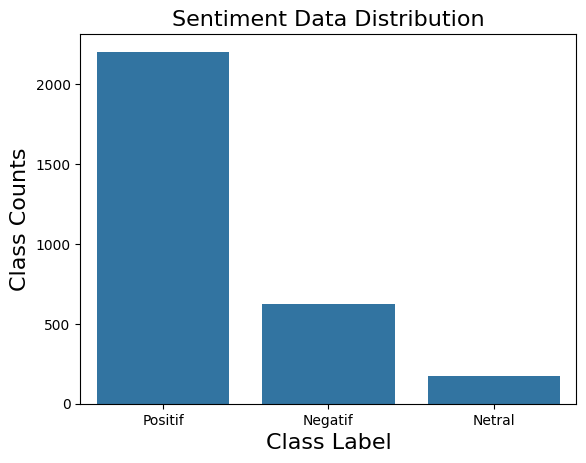

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Data Distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='horizontal')

positif = df[df['sentiment'] == 'Positif']
netral = df[df['sentiment'] == 'Netral']
negatif = df[df['sentiment'] == 'Negatif']


print('Total positive : {}'.format(len(positif)))
print('Total netral : {}'.format(len(netral)))
print('Total negative : {}'.format(len(negatif)))
print('Total data : {}'.format(len(df)))

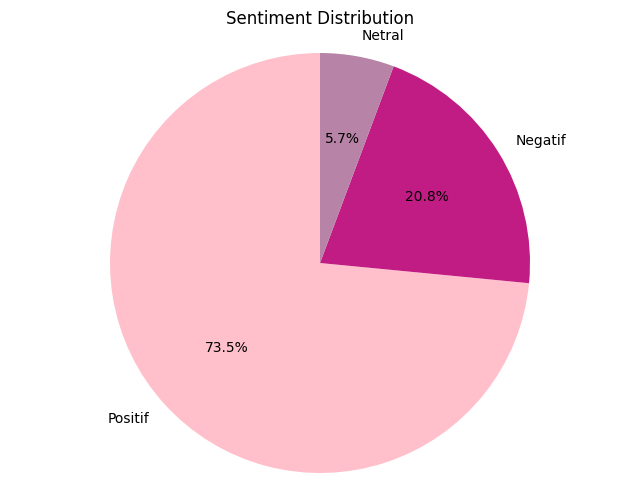

In [ ]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize= (8, 6))
colors = ['#FFC0CB', '#C11C84', '#B784A7']
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

## PREPROCESSING DATA

###Case Folding

In [ ]:
df = pd.DataFrame(reviews_data)
def case_folding(text):
  text = text.lower()
  text = text.strip()
  return text

df['content'] = df['content'].apply(case_folding)
result_case_folding = df['content']
result_case_folding

0                                                 lumayan
1       dgn aplikasi ini sangat fantastis buat semua o...
2       saya suka menggunakan aplikasi ini sangat meng...
3                                             sangat suka
4       reels yang di tampilkan video yang telah diblo...
                              ...                        
2995                                                bagus
2996                                                   ok
2997                                            luarbiasa
2998    salah satu sosial media yg baik di gunakan unt...
2999                                                keren
Name: content, Length: 3000, dtype: object

In [ ]:
df = pd.DataFrame(reviews_data)

def clean_text(df, content_col, new_col):

    df[new_col] = df[content_col].str.lower()
    df[new_col] = df[new_col].str.strip()
    return df

df['text clean'] = df['content'].str.lower()
df['text clean'] = df['text clean'].str.strip()
data_clean = clean_text(df, 'content', 'text_clean')
data_clean.head()

reviewId         userName  \
0  05041449-2cd3-4c74-9d89-4ea2b3bbb16e  Pengguna Google   
1  6caf737a-77ef-4c07-8304-3e5ebc7485b8  Pengguna Google   
2  deb4f1c5-5fd1-45b0-bde5-1e309accaa73  Pengguna Google   
3  2ad8f062-9095-4915-b59b-1981b9a506f7  Pengguna Google   
4  89a46d4e-350b-4748-8fbd-c498d2206b4b  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0                                            lumayan      5              0   
1  dgn aplikasi ini sangat fantastis buat semua o...      2              0   
2  saya suka menggunakan aplikasi ini sangat meng...      5              0   
3                                        sangat suka      5              0   
4  reels yang di tampilkan video yang telah diblo...      3              0   

  reviewCreatedVersion                  at replyContent repliedAt  \
0        375.0.0.38.66 2025-04-26 15:29:29         None      None   
1        377.1.0.48.63 2025-04-26 15:28:33         None      None   
2        376.1.0.55.68 2025-04-26 15:28:27         None      None   
3        377.1.0.48.63 2025-04-26 15:28:02         None      None   
4        364.0.0.35.86 2025-04-26 15:24:58         None      None   

      appVersion                                         text clean  \
0  375.0.0.38.66                                            lumayan   
1  377.1.0.48.63  dgn aplikasi ini sangat fantastis buat semua o...   
2  376.1.0.55.68  saya suka menggunakan aplikasi ini sangat meng...   
3  377.1.0.48.63                                        sangat suka   
4  364.0.0.35.86  reels yang di tampilkan video yang telah diblo...   

                                          text_clean  
0                                            lumayan  
1  dgn aplikasi ini sangat fantastis buat semua o...  
2  saya suka menggunakan aplikasi ini sangat meng...  
3                                        sangat suka  
4  reels yang di tampilkan video yang telah diblo...

###Filtering

In [ ]:
def filter_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebihan
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Hapus kata 1-2 huruf
    text = text.replace('\t', " ").replace('\n', " ").replace('\\', " ")  # Ganti tab/enter dengan spasi
    text = text.encode('ascii', 'ignore').decode('ascii')  # Hapus emoji
    text = re.sub(r"http\S+", "", text)  # Hapus URL
    text = re.sub(r"[@#]\w+", "", text)  # Hapus mention dan hashtag
    text = text.translate(str.maketrans("", "", string.punctuation))  # Hapus tanda baca lagi
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi ganda setelah pembersihan
    return text

df['content'] = df['content'].apply(filter_text)
df = df[df['content'].apply(lambda x: len(x) > 0)]
result_filtering = df['content']
result_filtering

0                                                 lumayan
1       dgn aplikasi ini sangat fantastis buat semua o...
2       saya suka menggunakan aplikasi ini sangat meng...
3                                             sangat suka
4       reels yang tampilkan video yang telah diblok a...
                              ...                        
2994                tolong kembaliin fitur catatan donggg
2995                                                bagus
2997                                            luarbiasa
2998    salah satu sosial media baik gunakan untuk men...
2999                                                keren
Name: content, Length: 2874, dtype: object

### Tokenizing

In [ ]:
def tokenize_word(text):
  return word_tokenize(text)

df['content'] = df['content'].apply(tokenize_word)

print('tokenizing Result : \n')
print(df['content'].to_string())

tokenizing Result : 

0                                               [lumayan]
1       [dgn, aplikasi, ini, sangat, fantastis, buat, ...
2       [saya, suka, menggunakan, aplikasi, ini, sanga...
3                                          [sangat, suka]
4       [reels, yang, tampilkan, video, yang, telah, d...
5       [tolong, dong, verivikasi, akunya, centang, bi...
6                                                [mantap]
7       [like, Instagram, but, its, really, hard, get,...
8                   [bagusss, banget, cantik, kayak, aku]
9       [cukup, baik, minusnya, kalo, kelamaan, pakek,...
10      [sosmed, yang, bagus, untuk, personal, brand, ...
11                                                [bagus]
12                                   [senang, aja, gituh]
13                                 [sangat, menyenangkan]
14      [tlg, Instagram, kenapa, Skg, kyk, begini, bua...
15      [apalah, pas, udah, tulis, sandi, tulisannya, ...
16      [mending, balikin, lagi, feed, nya, asli, 

### Normalization

In [ ]:
normalized = df

normalized_word = {
    'dgn':'dengan',
    'tlg':'tolong',
    'skg':'sekarang',
    'kyk':'kayak',
    'knp':'kenapa',
    'kenpaaaaa':'kenapa',
    'trzz':'terus',
    'apk':'aplikasi',
    'gk':'tidak',
    'mulu':'selalu',
    'sngt':'sangat',
    'udah':'sudah',
    'tpi':'tetapi',
    'sip':'bagus',
    'pdhl':'padahal',
    'gak':'tidak',
    'jdi':'jadi',
    'ksih':'kasih',
    'pdhldahlah':'padahal',
    'bGus':'bagus',
    'mulu':'selalu',
    'tolongg':'tolong',
    'kembaliin':'kembalikan',
    'note':'catatan',
    'nyaaa':'ya',
    'jos':'bagus',
    'sangattt':'sangat',
    'explore':'menjelajah',
    'wawwww':'keren',
    'lemot':'lama',
    'mantaf':'mantap',
    'bug':'error',
    'leg':'error',
    'menanbah':'menambah',
    'baguss':'bagus',
    'bangett':'banget',
    'sumpahh':'sumpah',
    'markotp':'mantap',
    'matap':'mantap',
    'karna':'karena',
    'cewe':'wanita',
    'sukaaaa':'suka',
    'bgus':'bagus',
    'afk':'aplikasi',
    'akunnya':'akun',
    'burik': 'jelek',
    'agk':'agak',
    'mksi':'makasih',
    'vidio':'video',
    'great':'bagus',
    'apps':'aplikasi',
    'sisain':'sisakan',
    'mqu':'mau',
    'sya':'saya',
    'tdk':'tidak',
    'jgn':'jangan',
    'verivikasi':'verifikasi',
    'sosmed':'sosial media',
    'gituh':'begitu',
    'balikin':'kembalikan',
    'gabisa':'tidak bisa',
    'maturnyewun':'terimakasih',
    'kaga':'tidak',
    'anj':'anjing',
    'bgt':'banget',
    'ajah':'aja',
    'sukaaaAAAAAA':'suka',
    'balikin':'kembalikan',
    'trimksh':'terimakasih',
    'yg':'yang',
    'gituh':'begitu',
    'jos':'bagus',
    'bguss':'bagus',
    'bgus':'bagus',
    'perface':'sempurna',
    'bosq':'bos',
    'seeeeeep':'keren',
    'dbes':'bagus',
    'bagu':'bagus',
    'sanget':'sangat',
    'trs':'terus',
    'sihhhhhhhhhhhhhhhhh':'ya',
    'mantul':'mantap betul',
    'akuu':'aku',
    'hmagak':'agak',
    'kereennnnn':'keren',
    'bgttt':'banget',
    'sippp':'bagus',
    'cakep':'keren',
    'swru':'seru',
    'mantab':'mantap',
    'senag':'senang',
    'apl':'aplikasi',
    'kluar':'keluar',
    'keselll':'kesal',
    'sngt':'sangat',
    'membanti':'membantu',
    'suk':'suka',
    'ntap':'mantap',
    'klo':'kalau',
    'napa':'kenapa',
    'gmna':'gimana',
    'puasss':'puas',
    'mantabzzzz':'mantap',
    'tetimagaci':'terimakasih',
    'tdi':'tadi',
    'Apk':'aplikasi',
    'lemottttdm':'lama',
    'gbisa':'gabisa',
    'npa':'kenapa',
    'dlu':'dulu',
    'trimakasih':'terimakasih',
    'skrng':'sekarang',
    'membutuhkanx':'membutuhkan',
    'matap':'mantap',
    'mantappp':'mantap',
    'banger':'banget',
    'mntap':'mantap'

}

for index, row in normalized.iterrows():
  if row[0] not in normalized_word:
    normalized_word[row[0]] = row[1]

def normalized_term(document):
  return [normalized_word[term] if term in normalized_word else term for term in document]

normalized['content'] = normalized['content'].apply(normalized_term)

print('Normalized Result : \n')
print(normalized['content'].to_string())

Normalized Result : 

0                                               [lumayan]
1       [aplikasi, fantastis, orang, pitur, cepat, pah...
2                                 [suka, aplikasi, hibur]
3                                                  [suka]
4       [reels, tampil, video, blok, video, jenis, mal...
5       [tolong, verifikasi, centang, biru, nunggu, dulu]
6                                                [mantap]
7       [like, instagram, but, its, really, hard, get,...
8                        [bagusss, banget, cantik, kayak]
9       [minus, kalo, pakek, aplikasi, suka, trus, buk...
10      [sosial media, bagus, personal, brand, informa...
11                                                [bagus]
12                                          [senang, aja]
13                                               [senang]
14      [tolong, instagram, sekarang, kayak, stori, ti...
15                      [pas, tulis, sandi, tulis, salah]
16                         [mending, feed, asli, m

### Stopwords

In [ ]:
indonesian_stopwords = set(stopwords.words('indonesian'))

custom_stopwords = {'nya', 'di', 'knp', 'dah', 'jos', 'anjayyy', 'ajg', 'woii', 'heh', 'sih', 'sii', 'eh', 'ahahahaa', 'suu', 'polll', 'tuh', 'ngk', 'njir', 'siii'}
indonesian_stopwords.update(custom_stopwords)

def remove_stopwords(text):
  return [word for word in text if word not in indonesian_stopwords]

normalized['content'] = normalized['content'].apply(remove_stopwords)

print('Stopwords removal Result : \n')
print(normalized['content'].to_string())

Stopwords removal Result : 

0                                               [lumayan]
1       [aplikasi, fantastis, orang, pitur, cepat, pah...
2                                 [suka, aplikasi, hibur]
3                                                  [suka]
4       [reels, tampil, video, blok, video, jenis, mal...
5             [tolong, verifikasi, centang, biru, nunggu]
6                                                [mantap]
7       [like, instagram, but, its, really, hard, get,...
8                        [bagusss, banget, cantik, kayak]
9       [minus, kalo, pakek, aplikasi, suka, trus, buk...
10      [sosial media, bagus, personal, brand, informa...
11                                                [bagus]
12                                          [senang, aja]
13                                               [senang]
14      [tolong, instagram, kayak, stori, loading, non...
15                      [pas, tulis, sandi, tulis, salah]
16                         [mending, feed, 

### Stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_words(text):
  stemmed_words = [stemmer.stem(word) for word in text]
  return stemmed_words

normalized['content'] = normalized['content'].apply(stem_words)

print('Stemming Result:')
for index, row in normalized.iterrows():
    print(f"Review {index + 1}: {' '.join(row['content'])}")

Stemming Result:
Review 1: lumayan
Review 2: aplikasi fantastis orang pitur cepat paham terimakasih
Review 3: suka aplikasi hibur
Review 4: suka
Review 5: reels tampil video blok video jenis malas buka
Review 6: tolong verifikasi centang biru nunggu
Review 7: mantap
Review 8: like instagram but its really hard get into
Review 9: bagusss banget cantik kayak
Review 10: minus kalo pakek aplikasi suka trus bukak just clear all the data
Review 11: sosial media bagus personal brand informasi tawa cerita kisa sedih dll btw doain biar dpt bnyk foll aamiin
Review 12: bagus
Review 13: senang aja
Review 14: senang
Review 15: tolong instagram kayak stori loading nonton reels kadang bnyak ngebug nyatiba ilang
Review 16: pas tulis sandi tulis salah
Review 17: mending feed asli mending
Review 18: good
Review 19: bagus
Review 20: good
Review 21: mendownload butuh
Review 23: keren banget
Review 24: tidak bisa bikin akun login
Review 25: senang
Review 26: amanah
Review 27: bagus banget deh cuman salur s

### WordCloud

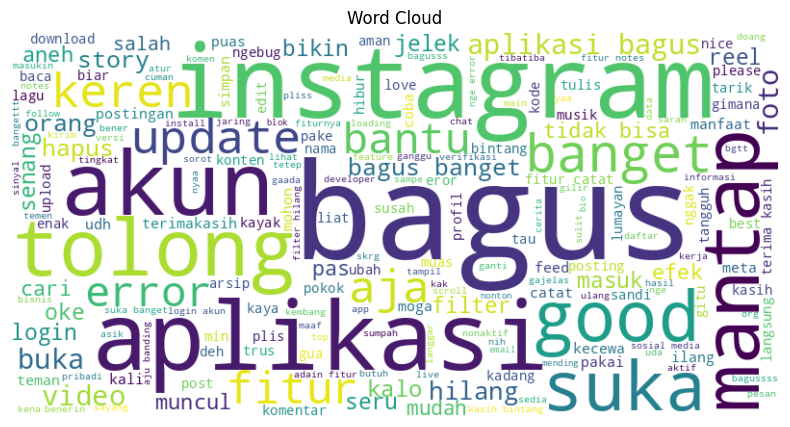

In [ ]:
all_words = [word for sublist in normalized['content'] for word in sublist]
text = " ".join(all_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

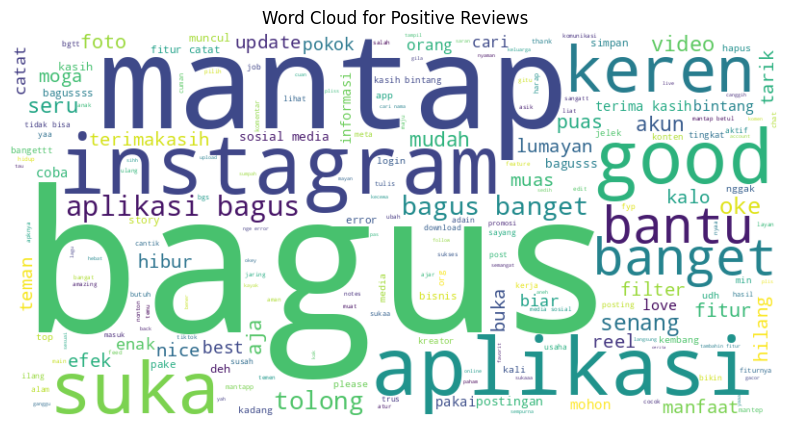

In [ ]:
positive_reviews = normalized[normalized['sentiment'] == 'Positif']['content']
positive_words = [word for sublist in positive_reviews for word in sublist]
positive_text = " ".join(positive_words)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

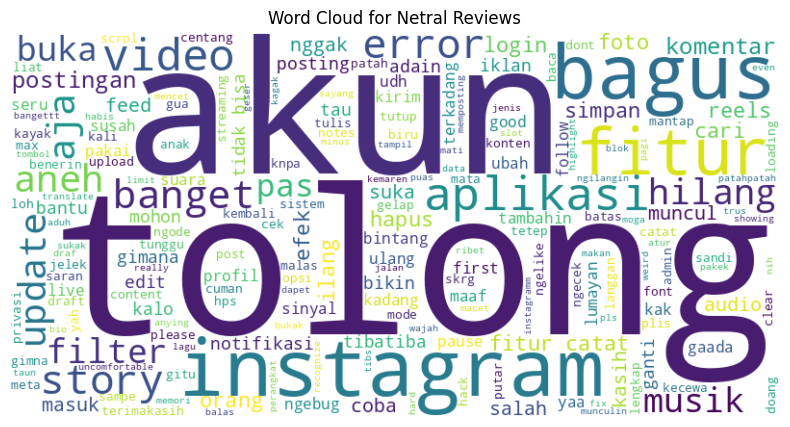

In [ ]:
netral_reviews = normalized[normalized['sentiment'] == 'Netral']['content'] # Make sure 'Netral' matches the label used in your dataframe
netral_words = [word for sublist in netral_reviews for word in sublist]
netral_text = " ".join(netral_words)

if len(netral_words) > 0:
    netral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(netral_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(netral_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Netral Reviews')
    plt.show()
else:
    print("Not enough words to generate a word cloud for neutral reviews.")

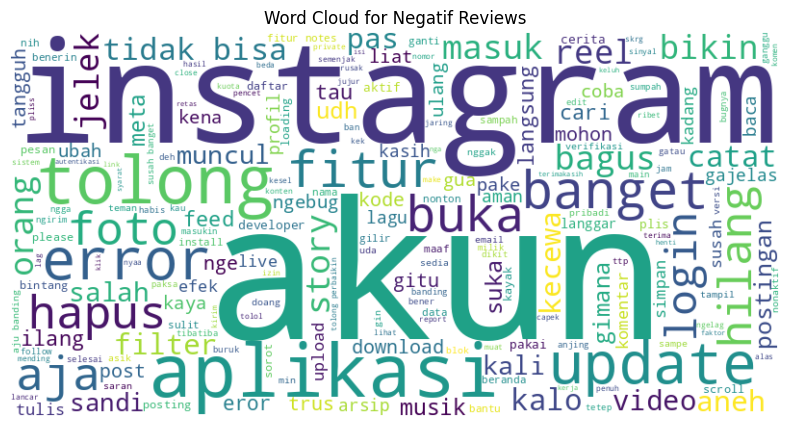

In [ ]:
negatif_reviews = normalized[normalized['sentiment'] == 'Negatif']['content']
negatif_words = [word for sublist in negatif_reviews for word in sublist]
negatif_text = " ".join(negatif_words)

if len(negatif_words) > 0:
    negatif_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negatif_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(negatif_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negatif Reviews')
    plt.show()
else:
    print("Not enough words to generate a word cloud for negative reviews.")

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gabungkan kata-kata dalam setiap list menjadi string
corpus = [' '.join(words) for words in normalized['content']]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names_out()
print(tfidf_matrix.toarray())
print(feature_names)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['aamiin' 'aaminn' 'abai' ... 'zoomnya' 'zuckerberak' 'zzzzz']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, normalized['sentiment'], test_size=0.2, random_state=42
)

print("hasil data latih:", X_train.shape)
print("hasil data uji:", X_test.shape)

hasil data latih: (2299, 2669)
hasil data uji: (575, 2669)


## BAG OF WORDS EXTRACTION

In [ ]:
bow_tranformer = CountVectorizer().fit([' '.join(tokens) for tokens in normalized['content']])
bow_tranformer.vocabulary_

{'lumayan': 1414,
 'aplikasi': 129,
 'fantastis': 712,
 'orang': 1785,
 'pitur': 1888,
 'cepat': 473,
 'paham': 1803,
 'terimakasih': 2385,
 'suka': 2297,
 'hibur': 942,
 'reels': 2008,
 'tampil': 2335,
 'video': 2569,
 'blok': 368,
 'jenis': 1102,
 'malas': 1441,
 'buka': 426,
 'tolong': 2451,
 'verifikasi': 2562,
 'centang': 472,
 'biru': 348,
 'nunggu': 1734,
 'mantap': 1457,
 'like': 1381,
 'instagram': 1023,
 'but': 440,
 'its': 1063,
 'really': 1997,
 'hard': 920,
 'get': 840,
 'into': 1050,
 'bagusss': 193,
 'banget': 228,
 'cantik': 455,
 'kayak': 1169,
 'minus': 1553,
 'kalo': 1147,
 'pakek': 1807,
 'trus': 2467,
 'bukak': 429,
 'just': 1129,
 'clear': 488,
 'all': 65,
 'the': 2404,
 'data': 543,
 'sosial': 2255,
 'media': 1495,
 'bagus': 184,
 'personal': 1873,
 'brand': 406,
 'informasi': 1003,
 'tawa': 2354,
 'cerita': 475,
 'kisa': 1244,
 'sedih': 2120,
 'dll': 615,
 'btw': 415,
 'doain': 623,
 'biar': 331,
 'dpt': 646,
 'bnyk': 384,
 'foll': 749,
 'aamiin': 0,
 'senang': 

In [ ]:
text_bow = bow_tranformer.transform([' '.join(tokens) for tokens in normalized['content']])
print(text_bow)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 10247 stored elements and shape (2874, 2669)>
  Coords	Values
  (0, 1414)	1
  (1, 129)	1
  (1, 473)	1
  (1, 712)	1
  (1, 1785)	1
  (1, 1803)	1
  (1, 1888)	1
  (1, 2385)	1
  (2, 129)	1
  (2, 942)	1
  (2, 2297)	1
  (3, 2297)	1
  (4, 368)	1
  (4, 426)	1
  (4, 1102)	1
  (4, 1441)	1
  (4, 2008)	1
  (4, 2335)	1
  (4, 2569)	2
  (5, 348)	1
  (5, 472)	1
  (5, 1734)	1
  (5, 2451)	1
  (5, 2562)	1
  (6, 1457)	1
  :	:
  (2864, 1078)	1
  (2864, 1201)	1
  (2864, 1202)	1
  (2864, 1481)	1
  (2864, 1826)	1
  (2864, 2282)	1
  (2864, 2434)	1
  (2865, 1457)	1
  (2866, 184)	1
  (2867, 182)	1
  (2868, 91)	2
  (2868, 1441)	1
  (2868, 2525)	1
  (2869, 465)	1
  (2869, 630)	1
  (2869, 733)	1
  (2869, 2451)	1
  (2870, 184)	1
  (2871, 1409)	1
  (2872, 948)	1
  (2872, 1103)	1
  (2872, 1495)	1
  (2872, 2063)	1
  (2872, 2255)	1
  (2873, 1212)	1


In [ ]:
X = text_bow.toarray()
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
X.shape

(2874, 2669)

In [ ]:
tfidf_transformer = TfidfVectorizer().fit(corpus)
print(tfidf_transformer)

tweet_tfidf = tfidf_transformer.transform(corpus)
print(tweet_tfidf)
print(tweet_tfidf.shape)

TfidfVectorizer()
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10247 stored elements and shape (2874, 2669)>
  Coords	Values
  (0, 1414)	1.0
  (1, 129)	0.18646739605189322
  (1, 473)	0.42280001468566364
  (1, 712)	0.4754772301022988
  (1, 1785)	0.28707539098489765
  (1, 1803)	0.41231841579107775
  (1, 1888)	0.45216719094032193
  (1, 2385)	0.321741412897403
  (2, 129)	0.4146504930778529
  (2, 942)	0.7507778574869772
  (2, 2297)	0.5141960494768094
  (3, 2297)	1.0
  (4, 368)	0.3748256038272907
  (4, 426)	0.24794662350395613
  (4, 1102)	0.4322412801700485
  (4, 1441)	0.41105086235336546
  (4, 2008)	0.26837407885316683
  (4, 2335)	0.34812883465379757
  (4, 2569)	0.49901359817775465
  (5, 348)	0.4805119025229544
  (5, 472)	0.49106652137119766
  (5, 1734)	0.5035499858744678
  (5, 2451)	0.2688697938050733
  (5, 2562)	0.4495647103890636
  (6, 1457)	1.0
  :	:
  (2864, 1078)	0.35583376353332546
  (2864, 1201)	0.41034027533572787
  (2864, 1202)	0.41034027533572787
  (2864, 1481)	0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    tweet_tfidf, normalized['sentiment'], test_size=0.2, random_state=42
)

In [ ]:
print("hasil data latih:", X_train.shape)
print("hasil data uji:", X_test.shape)
print("label data latih:", y_train.shape)
print("label data uji:", y_test.shape)

hasil data latih: (2299, 2669)
hasil data uji: (575, 2669)
label data latih: (2299,)
label data uji: (575,)


## ALGORITHM MULTINOMINAL NAIVE BAYES

In [ ]:
naive_bayes = BernoulliNB()

In [ ]:
model = MultinomialNB().fit(X_train, y_train)

In [ ]:
predection = model.predict(X_test)
predict = pd.Series(predection)
print(predection)

['Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif'
 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Negatif' 'Positif' 'Negatif' 'Positif' 'Positif'
 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Posi

In [ ]:
true_label = pd.Series(y_test)
print(true_label.to_string())

763      Netral
2159    Negatif
1344     Netral
1813    Negatif
978     Negatif
1111    Positif
1839    Positif
1317    Negatif
1138    Positif
2779    Negatif
2918    Positif
821     Negatif
899     Negatif
2080    Positif
2861    Negatif
1857    Positif
310      Netral
1176    Negatif
1078    Positif
1662    Positif
1391    Positif
2020    Positif
2282    Positif
1529    Positif
1990    Positif
384     Negatif
427     Positif
560     Positif
2921    Negatif
968     Negatif
1625    Positif
182     Positif
1647    Positif
2523    Positif
2618    Positif
2360    Negatif
2048    Positif
217     Positif
1896    Positif
2666    Negatif
981     Positif
2144    Positif
1293    Negatif
1525    Positif
1925    Negatif
1731    Positif
919     Positif
332     Positif
2565    Negatif
2929    Positif
1417    Positif
1313    Positif
2981    Positif
2449    Positif
338     Positif
1516    Positif
1081     Netral
2771    Negatif
478     Positif
433     Negatif
165     Positif
2704    Negatif
1751    

In [ ]:
accuracy_train = accuracy_score(y_train, model.predict(X_train))
accuracy_test = accuracy_score(y_test, predection)

print(f"Training Accuracy: {accuracy_train}")
print(f"Testing Accuracy: {accuracy_test}")

Training Accuracy: 0.8573292735972162
Testing Accuracy: 0.8


test time: 0.008s
accuracy: 0.800
              precision    recall  f1-score   support

     negatif       0.78      0.31      0.45       121
      netral       0.00      0.00      0.00        27
     positif       0.80      0.99      0.89       427

    accuracy                           0.80       575
   macro avg       0.53      0.43      0.44       575
weighted avg       0.76      0.80      0.75       575



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


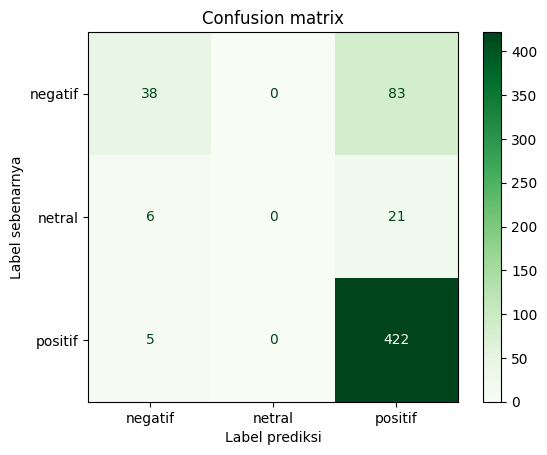

In [ ]:
# training model naives bayes
t = time()
y_pred = model.predict(X_test)

test_time = time() - t
print("test time: %0.3fs" % test_time)

score1 = metrics.accuracy_score(y_test, y_pred)
print("accuracy: %0.3f" % score1)

print(metrics.classification_report(y_test, y_pred, target_names=['negatif', 'netral', 'positif']))

columns = ['negatif','netral', 'positif']
confm = confusion_matrix(y_test, y_pred)
df = DataFrame(confm, index=columns, columns=columns)

disp = ConfusionMatrixDisplay(confusion_matrix=confm, display_labels=columns)
disp.plot(cmap='Greens', ax=plt.gca())

plt.title('Confusion matrix')
plt.xlabel('Label prediksi')
plt.ylabel('Label sebenarnya')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, target_names=['negatif', 'netral', 'positif'], output_dict=True)

accuracy = report['accuracy'] * 100
recall_negatif = report['negatif']['recall'] * 100
recall_netral = report['netral']['recall'] * 100
recall_positif = report['positif']['recall'] * 100
precision_negatif = report['negatif']['precision'] * 100
precision_netral = report['netral']['precision'] * 100
precision_positif = report['positif']['precision'] * 100

# menampilkan hasil akurasi
print(f"accuracy: {accuracy:.2f}%")
print(f"recall_negatif: {recall_negatif:.2f}%")
print(f"recall_netral: {recall_netral:.2f}%")
print(f"recall_positif: {recall_positif:.2f}%")
print(f"precision_negatif: {precision_negatif:.2f}%")
print(f"precision_netral: {precision_netral:.2f}%")
print(f"precision_positif: {precision_positif:.2f}%")

accuracy: 80.00%
recall_negatif: 31.40%
recall_netral: 0.00%
recall_positif: 98.83%
precision_negatif: 77.55%
precision_netral: 0.00%
precision_positif: 80.23%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
report = classification_report(
    y_test,
    y_pred,
    target_names=['negatif', 'netral', 'positif'],
    output_dict=True
)

accuracy = report['accuracy'] * 100

# Ambil nilai recall untuk masing-masing kelas
recall_negatif = report['negatif']['recall'] * 100
recall_netral = report['netral']['recall'] * 100
recall_positif = report['positif']['recall'] * 100

# Ambil nilai precision untuk masing-masing kelas
precision_negatif = report['negatif']['precision'] * 100
precision_netral = report['netral']['precision'] * 100
precision_positif = report['positif']['precision'] * 100

print(f"Accuracy            : {accuracy:.2f}%")
print(f"Recall Negatif      : {recall_negatif:.2f}%")
print(f"Recall Netral       : {recall_netral:.2f}%")
print(f"Recall Positif      : {recall_positif:.2f}%")
print(f"Precision Negatif   : {precision_negatif:.2f}%")
print(f"Precision Netral    : {precision_netral:.2f}%")
print(f"Precision Positif   : {precision_positif:.2f}%")

Accuracy            : 83.65%
Recall Negatif      : 51.24%
Recall Netral       : 3.70%
Recall Positif      : 97.89%
Precision Negatif   : 75.61%
Precision Netral    : 100.00%
Precision Positif   : 84.96%


## ALGORITHM LOGISTIC REGRESSION

In [ ]:
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

LogisticRegression()

In [ ]:
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())
print(y_pred_train_lr)
print(y_pred_test_lr)

['Positif' 'Positif' 'Positif' ... 'Positif' 'Negatif' 'Negatif']
['Negatif' 'Positif' 'Positif' 'Negatif' 'Negatif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Negatif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif'
 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Negatif' 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Negatif' 'Negatif' 'Positif' 'Negatif' 'Positif' 'Positif'
 'Negatif' 

In [ ]:
#evaluasi
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8729882557633754
Logistic Regression - accuracy_test: 0.8365217391304348


Test time: 0.001s
Accuracy: 0.837
              precision    recall  f1-score   support

     negatif       0.76      0.51      0.61       121
      netral       1.00      0.04      0.07        27
     positif       0.85      0.98      0.91       427

    accuracy                           0.84       575
   macro avg       0.87      0.51      0.53       575
weighted avg       0.84      0.84      0.81       575



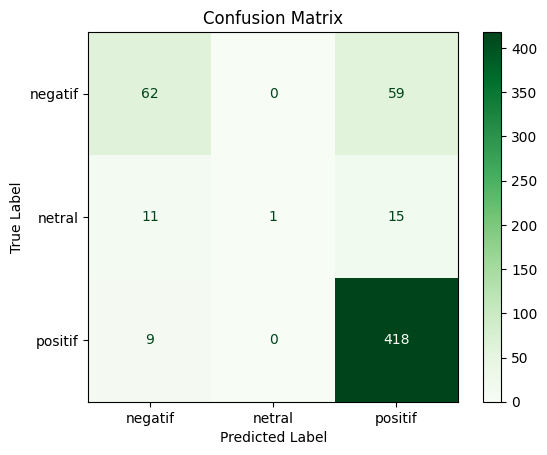

In [ ]:
# training model logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Mulai timing prediksi
t = time()
y_pred = model.predict(X_test)
test_time = time() - t

# Menampilkan waktu prediksi
print("Test time: %0.3fs" % test_time)

# Menghitung dan menampilkan akurasi
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %0.3f" % accuracy)

print(metrics.classification_report(y_test, y_pred, target_names=['negatif', 'netral', 'positif']))

# Membuat dan menampilkan confusion matrix
columns = ['negatif', 'netral', 'positif']

# endocing objek
label_encoder = LabelEncoder()

y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

confm = confusion_matrix(y_test_encoded, y_pred_encoded, labels=[0,1,2])
df_confm = DataFrame(confm, index=columns, columns=columns)

disp = ConfusionMatrixDisplay(confusion_matrix=confm, display_labels=columns)
disp.plot(cmap='Greens', ax=plt.gca())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

report = classification_report(
    y_test,
    y_pred,
    target_names=['negatif', 'netral', 'positif'],
    output_dict=True
)

accuracy = report['accuracy'] * 100
recall_negatif = report['negatif']['recall'] * 100
recall_netral = report['netral']['recall'] * 100
recall_positif = report['positif']['recall'] * 100
precision_negatif = report['negatif']['precision'] * 100
precision_netral = report['netral']['precision'] * 100
precision_positif = report['positif']['precision'] * 100

#menampilkan hasil akurasi
print(f"Accuracy            : {accuracy:.2f}%")
print(f"Recall Negatif      : {recall_negatif:.2f}%")
print(f"Recall Netral       : {recall_netral:.2f}%")
print(f"Recall Positif      : {recall_positif:.2f}%")
print(f"Precision Negatif   : {precision_negatif:.2f}%")
print(f"Precision Netral    : {precision_netral:.2f}%")
print(f"Precision Positif   : {precision_positif:.2f}%")

Accuracy            : 83.65%
Recall Negatif      : 51.24%
Recall Netral       : 3.70%
Recall Positif      : 97.89%
Precision Negatif   : 75.61%
Precision Netral    : 100.00%
Precision Positif   : 84.96%
